# Evaluate Models

This notebook will be used to compare all three models and a random baseline in terms of their accuracy in predicting the book in which a sentence belongs and their efficiency in doing so, measured by the time it takes to make all predictions. The three models will be compared based on the validation dataset. Once a final model is chosen, some hyperparameter tuning and error analysis will be conducted to try to improve its score. Finally, the improved model will be tested against the unseen testing dataset to obtain a final accuracy metric.

In [36]:
# import required libraries
import pandas as pd
import numpy as np

import json
from time import time
from random import choices

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics

## Import Training and Validation Datasets

In [2]:
# define the path for the processed datasets
PATH = "data/processed/"

# read the training dataset
hp_sentences_train = pd.read_csv(f"{PATH}training_df.csv")

# read the validation dataset
hp_sentences_val = pd.read_csv(f"{PATH}validation_df.csv")

In [3]:
# show the first 5 rows of the training dataset
hp_sentences_train.head()

,sentence,book
0,A wild-looking old woman dressed all in green ...,1
1,Harry was thinking about this time yesterday a...,1
2,"He had been down at Hagrid’s hut, helping him ...",1
3,"“We’re looking for a big, old-fashioned one — ...",1
4,I forbid you to tell the boy anything!” A brav...,1


In [4]:
# show the first 5 rows of the validation dataset
hp_sentences_val.head()

,sentence,book
0,“She obviously makes more of an effort if you’...,1
1,We’ve eaten all our food and you still seem to...,1
2,"Please cheer up, Hagrid, we saved the Stone, i...",1
3,He gave his father a sharp tap on the head wit...,1
4,He kept threatening to tell her what really bi...,1


## Create a Random Baseline
I first want to create a benchmark based on predicting the books randomly to see how much more accurate our models are. To do so, I will calculate the distribution of sentences per book in the training dataset and used this distribution to create a column in the validation dataframe with the random prediction.

In [5]:
# initiate dictionary that will hold the book distribution from the training dataset
book_dist = {}

# capture the number of sentences from each book and the total number of sentences in the training set
sentences_book = hp_sentences_train["book"].value_counts()
total_sentences = sentences_book.sum()

# determine the proportion of sentences for each book
for book in range(1,8):
    book_dist[book] = sentences_book[book] / total_sentences
    
book_dist

{1: 0.0788126140742243,
 2: 0.0872794564996958,
 3: 0.1150628675725005,
 4: 0.18472419387548164,
 5: 0.2113668627053336,
 6: 0.1458629081322247,
 7: 0.17689109714053944}

In [6]:
# extract the population (1-7) and weights (proportion/book) of the distribution
population = list(book_dist.keys())
weights = list(book_dist.values())

# calculate the total number of sentences in the validation set
validation_count = len(hp_sentences_val)

# generate the random prediction for each sentence in the validation set
random_predictions = choices(population, weights, k = validation_count)

# add the random predictions as a column in the validation dataframe
hp_sentences_val["Random"] = random_predictions

hp_sentences_val.head()

,sentence,book,Random
0,“She obviously makes more of an effort if you’...,1,7
1,We’ve eaten all our food and you still seem to...,1,3
2,"Please cheer up, Hagrid, we saved the Stone, i...",1,5
3,He gave his father a sharp tap on the head wit...,1,6
4,He kept threatening to tell her what really bi...,1,4


## Re-Train Models
Using the same steps used and described in the other two notebooks, I will train the models to be used in this notebook.

### Custom Naive bayes

In [7]:
# read the frequency JSON file as a dictionary
with open(f"{PATH}freq_dict.json", "r") as freq_dict_file:
    freq = json.load(freq_dict_file)

# read the book counts JSON file as a dictionary
with open(f"{PATH}book_counts_dict.json", "r") as book_counts_dict_file:
    book_counts = json.load(book_counts_dict_file)

In [8]:
# import sentence preprocessing function
from utils import process_sentence

In [9]:
def predict_book (df, sentence, freq, book_counts, process_sentence=process_sentence):
    """
    Predicts the book in which a sentence appears using the Naive Bayes technique.
    
    Parameters:
        df (dataframe): dataframe with the sentences from the Harry Potter books
        sentence (string): sentence from a Harry Potter book
        
    Returns:
        book (integer in the range 1-7): Harry Potter book in which the sentence is predicted to appear
    """
    
    # get the list of processed tokens for the sentence
    tokens = process_sentence(sentence)
    
    # initiate dictionary that will hold the probability of the sentence appearing in each book
    prob_books = {}
    
    # iterate through the seven book possibilities
    for book in range(1, 8):
        
        # store the total number of sentences in the dataframe and the number of sentences in the iterated book
        total_sentences = len(df)
        book_sentences = len(df[df["book"] == book])
        
        # calculate the probability of a random sentence appearing in the iterated book
        prob_books[book] = book_sentences / total_sentences
        
        # iterate through the tokens in the processed sentence
        for token in tokens:
            
            # calculate the probability that the word appears in the iterated book
            token_book_prob = freq.get(token + str(book), 0) / book_counts[str(book)]
            
            # multiply the running probability of the sentence appearing in the iterated book 
            # by the probability of the word appearing in the book
            prob_books[book] *= token_book_prob
    
    # return the book with the highest probability for the given sentence
    return max(prob_books, key=prob_books.get)

In [10]:
# create new column in dataframe with the predicted book and measure how long it took in seconds
start_time = time()
hp_sentences_val["CustomNB"] = hp_sentences_val["sentence"].apply(lambda sentence: predict_book(hp_sentences_val, sentence, freq, book_counts))
elapsed_time_customNB = time() - start_time

### Pre-Built Naive Bayes

In [11]:
# create a pipeline with the three steps required to train the classifier and make predictions
hp_classifier_nb = Pipeline([
    ('count_vect', CountVectorizer()), # create a word count vector
    ('freq_vect', TfidfTransformer()), # normalize the term frequencies
    ('classify', MultinomialNB()) # use a Naive Bayes multinomial classifier
])

In [12]:
# train the model on the sentences in the training dataset
hp_classifier_nb.fit(hp_sentences_train["sentence"], hp_sentences_train["book"])

Pipeline(steps=[('count_vect', CountVectorizer()),
                ('freq_vect', TfidfTransformer()),
                ('classify', MultinomialNB())])

In [13]:
# create new column in dataframe with the predicted book and measure how long it took in seconds
start_time = time()
hp_sentences_val["PrebuiltNB"] = hp_classifier_nb.predict(hp_sentences_val["sentence"])
elapsed_time_prebuiltNB = time() - start_time

### Linear SVC

In [14]:
# create a pipeline with the three steps required to train the classifier and make predictions
hp_classifier_svc = Pipeline([
    ('count_vect', CountVectorizer()), # create a word count vector
    ('freq_vect', TfidfTransformer()), # normalize the term frequencies
    ('classify', LinearSVC()) # use a Linear SVC classifier
])

In [15]:
# train the model on the sentences in the training dataset
hp_classifier_svc.fit(hp_sentences_train["sentence"], hp_sentences_train["book"])

Pipeline(steps=[('count_vect', CountVectorizer()),
                ('freq_vect', TfidfTransformer()), ('classify', LinearSVC())])

In [16]:
# create new column in dataframe with the predicted book and measure how long it took in seconds
start_time = time()
hp_sentences_val["LinearSVC"] = hp_classifier_svc.predict(hp_sentences_val["sentence"])
elapsed_time_linearSVC = time() - start_time

## Evaluate & Compare Models
Now that the models have been trained and produced predictions on our validation dataset, it is time to evaluate their results and compare their performances. I will perform the following activities to identify the model to keep and to better understand their behaviors:
1. Compare each model's accuracy and efficiency
2. Analyze each model's classification report and confusion matrix
3. Compare the custom & pre-built Naive Bayes models
4. Compare the accuracy per book of each model

### 1. Compare each model's accuracy and efficiency

In [17]:
# import accuracy function
from utils import calc_accuracy

In [18]:
# show the first 5 rows of the validation datasets with the predictions from each model
hp_sentences_val.head()

,sentence,book,Random,CustomNB,PrebuiltNB,LinearSVC
0,“She obviously makes more of an effort if you’...,1,7,5,5,7
1,We’ve eaten all our food and you still seem to...,1,3,1,5,1
2,"Please cheer up, Hagrid, we saved the Stone, i...",1,5,1,5,1
3,He gave his father a sharp tap on the head wit...,1,6,1,4,1
4,He kept threatening to tell her what really bi...,1,4,1,5,3


In [19]:
# create list with the accuracy metric of each model
MODEL_NAMES = ["Random", "CustomNB", "PrebuiltNB", "LinearSVC"]
accuracy_list = []

for model in MODEL_NAMES:
    accuracy_list.append(calc_accuracy(hp_sentences_val["book"], hp_sentences_val[model]))

    
# create dataframe with the accuracy and efficiency (time to predict) of each model
model_performance_df = pd.DataFrame(data = {
                                        "Accuracy": accuracy_list,
                                        "Efficiency": [np.nan, elapsed_time_customNB, elapsed_time_prebuiltNB, elapsed_time_linearSVC]
                                    }, index = MODEL_NAMES)

# display the dataframe
model_performance_df

,Accuracy,Efficiency
Random,0.153430,NaN
CustomNB,0.371639,213.782257
PrebuiltNB,0.387878,0.327625
LinearSVC,0.453368,0.266160


We can see that the custom model is the least accurate, slightly behind the pre-built Naive bayes model, but is by far the least efficient having took 192 seconds to make all predictions. The two pre-built models took approximately the same amount of time to make their predictions (~0.2 seconds), but the Linear SVC model was the clear winner in terms of accuracy at 45.34%. All models performed significantly better than the random baseline, meaning the models are effective at predicting a book based on the wording used in the sentence. For its high accuracy and efficiency, I will keep the LinearSVC model to complete the project, but I will still spend more time to analyze each model's performance.

### 2. Analyze each model's classification report and confusion matrix

In [20]:
# print classification report for custom naive bayes
print("Custom Naive Bayes\n\n")
print("Classification Report:")
print(metrics.classification_report(hp_sentences_val["book"], hp_sentences_val["CustomNB"]))

# print confusion matrix for custom naive bayes
print("\nConfusion Matrix:")
print(metrics.confusion_matrix(hp_sentences_val["book"], hp_sentences_val["CustomNB"]))

Custom Naive Bayes


Classification Report:
              precision    recall  f1-score   support

           1       0.15      0.39      0.22       888
           2       0.39      0.25      0.30       983
           3       0.41      0.31      0.35      1297
           4       0.47      0.38      0.42      2082
           5       0.40      0.42      0.41      2382
           6       0.40      0.32      0.36      1644
           7       0.46      0.43      0.44      1993

    accuracy                           0.37     11269
   macro avg       0.38      0.36      0.36     11269
weighted avg       0.40      0.37      0.38     11269


Confusion Matrix:
[[ 348   61  104  102  132   57   84]
 [ 203  243   95  120  161   74   87]
 [ 203   71  408  145  251   92  127]
 [ 325   85  122  791  406  148  205]
 [ 483   75  112  225 1010  209  268]
 [ 321   46   88  133  291  533  232]
 [ 363   48   76  153  284  214  855]]


* Based on the precision scores per book, we can trust the predictions the most for the fourth book (0.47) and the least for the first book (0.15).
* Based on the recall scores per book, the model is most accurate for sentences from the seventh book (0.43) and the least for sentences from the second book (0.25).
* When considering both precision and recall through the F1 scores, the model performs best for the seventh book (0.44) and worst for first book (0.22).
* The confusion matrix seems to indicate that there is generally the same amount of false positives as false negatives for each book. However, we can notice that there are considerably more false positives than false negatives for the first book which is confirmed by its poor precision.

In [21]:
# print classification report for pre-built naive bayes
print("Pre-Built Naive Bayes\n\n")
print("Classification Report:")
print(metrics.classification_report(hp_sentences_val["book"], hp_sentences_val["PrebuiltNB"]))

# print confusion matrix for pre-built naive bayes
print("\nConfusion Matrix:")
print(metrics.confusion_matrix(hp_sentences_val["book"], hp_sentences_val["PrebuiltNB"]))

Pre-Built Naive Bayes


Classification Report:
              precision    recall  f1-score   support

           1       0.63      0.01      0.03       888
           2       0.74      0.03      0.06       983
           3       0.79      0.09      0.15      1297
           4       0.47      0.46      0.46      2082
           5       0.30      0.83      0.44      2382
           6       0.64      0.19      0.29      1644
           7       0.52      0.49      0.50      1993

    accuracy                           0.39     11269
   macro avg       0.58      0.30      0.28     11269
weighted avg       0.54      0.39      0.33     11269


Confusion Matrix:
[[  12    1    6  173  585   14   97]
 [   0   29    5  197  616   36  100]
 [   0    1  111  199  839   24  123]
 [   1    2    3  957  933   22  164]
 [   2    0    2  192 1984   27  175]
 [   3    4    6  155  916  307  253]
 [   1    2    7  164  800   48  971]]


* An initial observation for this model is that unlike the custom Naive Bayes, the pre-built version presents much more imbalance between its precision (avg 0.58) and recall (0.30). In practice, this means that its predictions can generally be trusted more, but it is worst at making a prediction.
* The confusion matrix shows that the model performs poorly at predicting the first three books which is confirmed by their recall scores of 0.01, 0.03 and 0.09, respectively.
* The model is highly accurate at predicting the fifth book (recall = 0.83), but its predictions can't be trusted because the model over-predicts this book (precision = 0.30). This is likely due to the fact that the fifth book has the most sentences so the model is biased towards it.

In [22]:
# print classification report for linear SVC
print("Linear SVC\n\n")
print("Classification Report:")
print(metrics.classification_report(hp_sentences_val["book"], hp_sentences_val["LinearSVC"]))

# print confusion matrix for linear SVC
print("\nConfusion Matrix:")
print(metrics.confusion_matrix(hp_sentences_val["book"], hp_sentences_val["LinearSVC"]))

Linear SVC


Classification Report:
              precision    recall  f1-score   support

           1       0.38      0.34      0.36       888
           2       0.45      0.31      0.37       983
           3       0.42      0.39      0.40      1297
           4       0.48      0.50      0.49      2082
           5       0.45      0.52      0.48      2382
           6       0.44      0.40      0.42      1644
           7       0.49      0.53      0.51      1993

    accuracy                           0.45     11269
   macro avg       0.44      0.43      0.43     11269
weighted avg       0.45      0.45      0.45     11269


Confusion Matrix:
[[ 305   49  102  130  130   72  100]
 [  86  306  107  128  175   82   99]
 [  97   66  509  174  211   89  151]
 [  88   85  147 1037  347  161  217]
 [  98   73  145  306 1232  236  292]
 [  63   47  111  175  326  656  266]
 [  61   52   96  205  308  207 1064]]


* Unlike the pre-built Naive Bayes, this model seems more balanced in terms of its precision and recall and performs generally better across books.
* Based on the precision scores per book, we can trust the predictions the most for the seventh book (0.49) and the least for the first book (0.38).
* Based on the recall scores per book, the model is most accurate for sentences from the seventh book (0.53) and the least for sentences from the second book (0.31).
* When considering both precision and recall through the F1 scores, the model performs best for the seventh book (0.51) and worst for first book (0.36).
* While the scores are significantly superior for this model, the book rankings for each metrix is the same as the custom Naive Bayes, meaning that the models behave similarly which is not the case for the pre-built Naive Bayes.

### 3. Compare the custom & pre-built Naive Bayes models
In theory, the custom and pre-built models are based on the same algorithms with a different implementation. Therefore, I would expect them to behave similarly when making predictions. However, as discussed in the previous section, the metrics seem to indicate that the custom Naive Bayes model is more similar to Linear SVC model, although less accurate. I will now explore the relationship between the custom and pre-built NB models more attentively.

In [33]:
# count and calculate proportion of instances where the prediction was the same between the custom and pre-built NB models
count_same = sum(hp_sentences_val["CustomNB"] == hp_sentences_val["PrebuiltNB"])
prop_same = round((count_same / len(hp_sentences_val)) * 100, 2)

# print the count and proportion
print(f"There are {count_same} instances in which the custom and pre-built Naive Bayes models predicted the same book which represents {prop_same}% of sentences in the validation set.")

There are 4901 instances in which the custom and pre-built Naive Bayes models predicted the same book which represents 43.49% of sentences in the validation set.


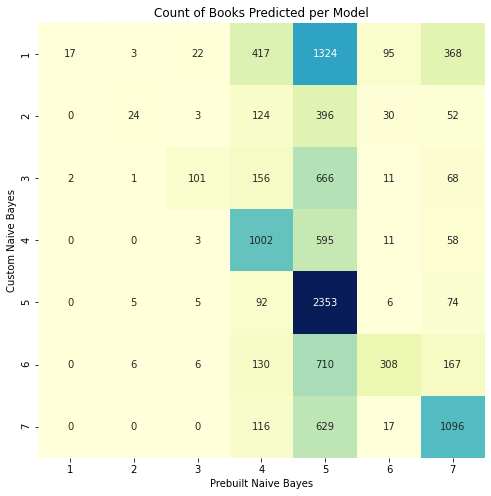

In [80]:
# create arrays with the predictions from the custom and pre-built NB models
custom_array = hp_sentences_val["CustomNB"]
prebuilt_array = hp_sentences_val["PrebuiltNB"]

# create a dataframe with the confusion matrix between the custom and pre-built NB models 
data = pd.DataFrame(metrics.confusion_matrix(custom_array, prebuilt_array),\
                    index = list(range(1,8)),\
                    columns = list(range(1,8)))

# visualize the confusion matrix through a heatmap
fig, ax = plt.subplots(figsize=(8, 8))

ax = sns.heatmap(data, cbar=False, annot = True, cmap = "YlGnBu", fmt = "d")

ax.set_title("Count of Books Predicted per Model")

plt.xlabel("Prebuilt Naive Bayes")
plt.ylabel("Custom Naive Bayes")

plt.show()

* The fifth column contains the most observations. This is explained by the fact that, as mentioned earlier, the pre-built Naive Bayes model over-predicts the fifth book.
* In general, most observations occur on the diagonal line from the top-left to the bottom-right which represent instances where both models predicted the same book.
* 368 sentences were classified in book 7 by the pre-built model and book 1 by the custom model. The opposite however, pre-built = 1 and custom = 7, is 0. The similar phenomenon occurs for combinations (4,1) and (4,2). This is again explained by the bias towards later books by the pre-built model.

### 4. Compare the accuracy per book of each model

The last comparison analysis I will perform is visualizing the accuracy per book of each model to see if there is a common pattern between models. This was partly done when interpreting their classification reports. For this exercise, accuracy will refer to recall: TP / (TP + FN).

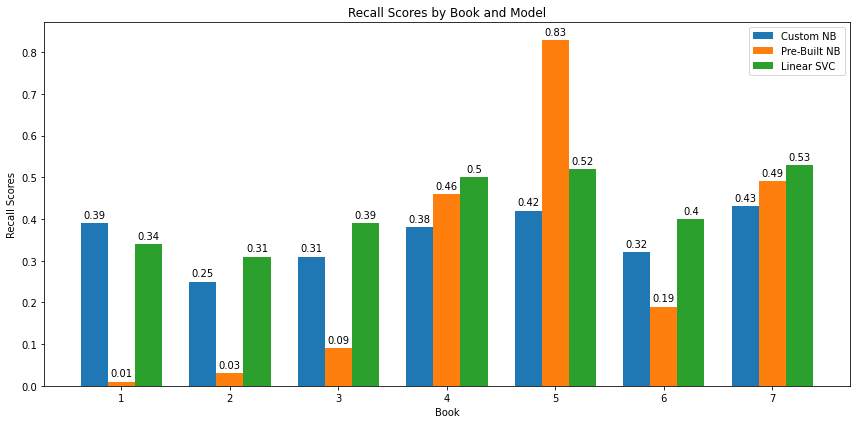

In [102]:
# create arrays with the predictions from the three models and the true values
customNB_array = hp_sentences_val["CustomNB"]
prebuiltNB_array = hp_sentences_val["PrebuiltNB"]
linearSVC_array = hp_sentences_val["LinearSVC"]
true_array = hp_sentences_val["book"]

# create arrays with the recall score per book for each of the three models
customNB_recall = np.around(metrics.recall_score(true_array, customNB_array, average = None), decimals = 2)
prebuiltNB_recall = np.around(metrics.recall_score(true_array, prebuiltNB_array, average = None), decimals = 2)
linearSVC_recall = np.around(metrics.recall_score(true_array, linearSVC_array, average = None), decimals = 2)

# plot the recall score per book for each of the three models on the same bar chart
labels = list(range(1, 8))
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, customNB_recall, width, label='Custom NB')
rects2 = ax.bar(x, prebuiltNB_recall, width, label='Pre-Built NB')
rects3 = ax.bar(x + width, linearSVC_recall, width, label='Linear SVC')

ax.set_ylabel('Recall Scores')
ax.set_xlabel('Book')
ax.set_title('Recall Scores by Book and Model')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()

As was previously discussed, the pre-built Naive Bayes model seems to only perform well on the fifth book, and falls short of the other models for the other books (especially the first three). The Custom Naive Bayes and Linear SVC models seem to follow the a similar pattern across the seven books. There seems to be a slight upward trend in accuracy as the books progress which is likely due to the fact that the later books have more sentences to learn from.

# Notebook Complete!